In [1]:
import rospy
import rospkg
from sensor_msgs.msg import Image, PointCloud2
import sensor_msgs.point_cloud2 as pc2
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt, image, pyplot as plt
import open3d
from sensor_msgs.msg import CameraInfo

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def imgmsg_to_cv2(img_msg):
    dtype = np.dtype("uint8") # Hardcode to 8 bits...
    dtype = dtype.newbyteorder('>' if img_msg.is_bigendian else '<')
    image_opencv = np.ndarray(shape=(img_msg.height, img_msg.width, 3), # and three channels of data. Since OpenCV works with bgr natively, we don't need to reorder the channels.
                    dtype=dtype, buffer=img_msg.data)
    # If the byt order is different between the message and the system.
    if img_msg.is_bigendian == (sys.byteorder == 'little'):
        image_opencv = image_opencv.byteswap().newbyteorder()
    return image_opencv

def cv2_to_imgmsg(cv_image):
    img_msg = Image()
    img_msg.height = cv_image.shape[0]
    img_msg.width = cv_image.shape[1]
    img_msg.encoding = "bgr8"
    img_msg.is_bigendian = 0
    img_msg.data = cv_image.tostring()
    img_msg.step = len(img_msg.data) // img_msg.height # That double line is actually integer division, not a comment
    return img_msg

def load_yolo(model_dir):
    net = cv2.dnn.readNet(model_dir + "yolo-obj.weights", model_dir + "yolo-obj.cfg")
    classes = []
    with open(model_dir + "obj.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i-1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

def detect_objects(img, net, outputLayers):
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs

def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            conf = scores[class_id]
            if conf > 0.3:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confs.append(float(conf))
                class_ids.append(class_id)
    return boxes, confs, class_ids

def draw_labels(boxes, confs, colors, class_ids, classes, img): 
    import random
    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = [random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)]
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, [255, 255, 255], 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('my picture')
    plt.show()
    
def cluster_boxes(boxes, confs, class_ids, classes):
    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    result = []
    for i in range(len(boxes)):
        if i in indexes:
            result.append([boxes[i], str(classes[class_ids[i]])])
    return result

def convert_pointcloud2_to_pc(pointcloud2_msg):
    pc_data = pc2.read_points(pointcloud2_msg, skip_nans=True, field_names=("x", "y", "z"))
    pc_list = []

    for p in pc_data:
        pc_list.append([p[0], p[1], p[2]])

    pc_array = np.array(pc_list, dtype=np.float32)

    return pc_array

def filter_points(pointcloud, camera_matrix, bbox):
    # Convert points to homogeneous coordinates
    #     homogeneous_points = np.hstack((pointcloud, np.ones((pointcloud.shape[0], 1))))
    
    # Project points onto image plane
    projected_points = np.dot(pointcloud, camera_matrix.T)
    
    # Convert from homogeneous to 2D coordinates
    x = projected_points[:, 0] / projected_points[:, 2]
    y = projected_points[:, 1] / projected_points[:, 2]

    # Define bounding box limits
    bx, by, bw, bh = bbox
    xmin = bx
    ymin = by
    xmax = bx + bw
    ymax = by + bh
    
    # Check which points lie within the bounding box
    mask = (x >= xmin) & (x <= xmax) & (y >= ymin) & (y <= ymax)
    
    # Return only the points within the bounding box
    return pointcloud[mask], pointcloud[~mask]

def keep_point_on_plane(plane_model, pointcloud):
    A, B, C, D = plane_model
    # Compute the distances from each point to the plane
    distances = np.abs(A * pointcloud[:, 0] + B * pointcloud[:, 1] + C * pointcloud[:, 2] + D) / np.sqrt(A**2 + B**2 + C**2)
    # Define the distance threshold - points with distance less than this are considered to be on the plane
    threshold = 0.01
    # Select points where the distance is less than the threshold
    return pointcloud[distances < threshold]

def get_door_direction(plane_model, handle_point):
    door_direction = plane_model[:3] / np.linalg.norm(plane_model[:3])
    if door_direction.dot(handle_point) > 0:
        return -door_direction
    return door_direction

In [3]:
rospy.init_node('door_openner', anonymous=True)
darknet_dir = rospkg.RosPack().get_path('door_opener') + '/script/darknet/'
model, classes, colors, output_layers  = load_yolo(darknet_dir)

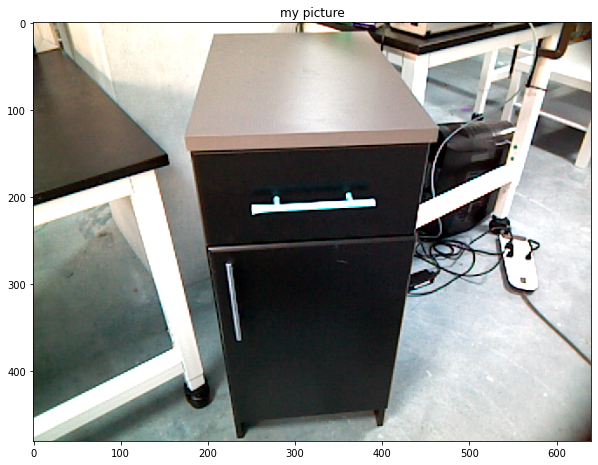

In [4]:
# get image
image = rospy.wait_for_message("/head_camera/rgb/image_rect_color", Image)
cv2_img = imgmsg_to_cv2(image)
cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(cv2_img)
plt.title('my picture')
plt.show()

In [5]:
blob, outputs = detect_objects(cv2_img, model, output_layers)
boxes, confs, class_ids = get_box_dimensions(outputs, cv2_img.shape[0], cv2_img.shape[1])
# draw_labels(boxes, confs, colors, class_ids, classes, cv2_img)

In [6]:
# get pointcloud from camera
pointcloud_raw = rospy.wait_for_message("/head_camera/depth_downsample/points", PointCloud2)
pointcloud = convert_pointcloud2_to_pc(pointcloud_raw)

# need to find the handle in the pointcloud
## need to get the camera matrix
camera_info = rospy.wait_for_message('/head_camera/rgb/camera_info', CameraInfo)
camera_matrix = np.reshape(camera_info.K, (3, 3))

In [7]:
handle_directions = []
handle_pcs = []

for b, n in cluster_boxes(boxes, confs, class_ids, classes):
    if n == 'handle':
        filter_pointcloud, rest_pointcloud = filter_points(pointcloud, camera_matrix, b)
        
        handle_point = np.mean(filter_pointcloud, axis=0)
        
        # get the rest point close to this mean point
        distances = np.sqrt(np.sum((rest_pointcloud - handle_point)**2, axis=1))
        radius_points = rest_pointcloud[distances < 0.2]

        # do plane fitting
        pcd = open3d.geometry.PointCloud()
        pcd.points = open3d.utility.Vector3dVector(radius_points)

        # Perform plane segmentation
        plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                                 ransac_n=3,
                                                 num_iterations=1000)

        door_pc = keep_point_on_plane(plane_model, rest_pointcloud)
        door_direction = get_door_direction(plane_model, handle_point)
        handle_directions.append(np.concatenate((handle_point, door_direction)))
        handle_pcs.append(filter_pointcloud)

In [8]:
# downsample pc
# Perform voxel grid downsampling
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(pointcloud)
downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.05)

# Convert back to numpy array
downsampled_pointcloud = np.asarray(downsampled_pcd.points)

<IPython.core.display.Javascript object>


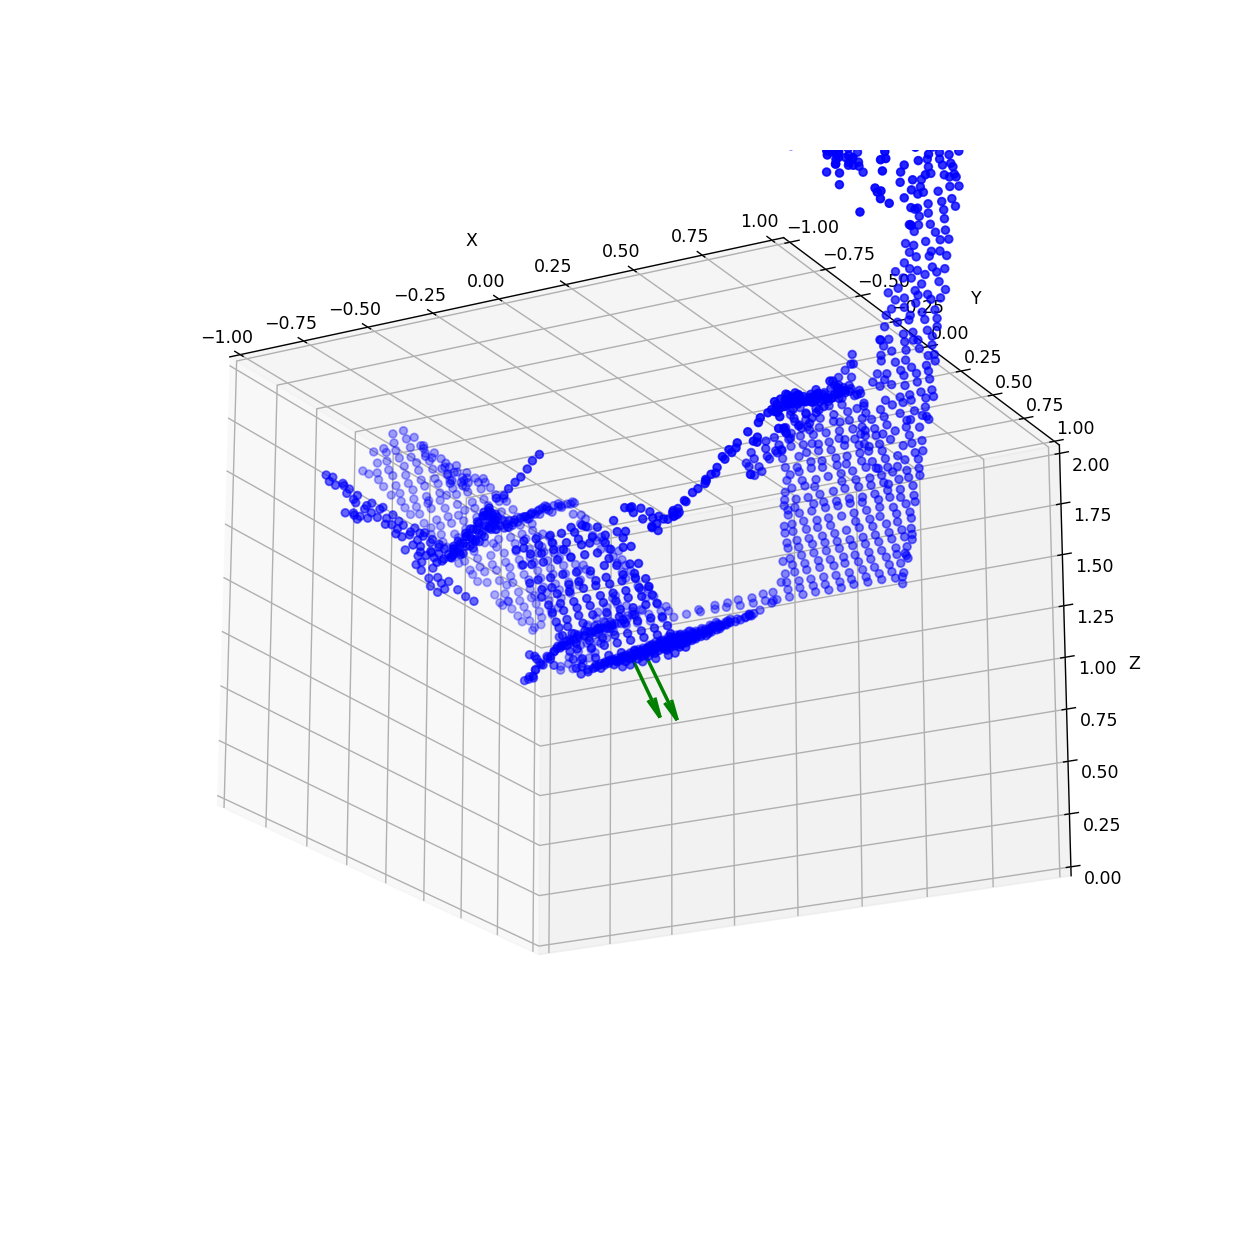

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot, with point_cloud[:, 0] as x, point_cloud[:, 1] as y and point_cloud[:, 2] as z
ax.scatter(downsampled_pointcloud[:, 0], downsampled_pointcloud[:, 1], downsampled_pointcloud[:, 2], c='blue')
# ax.scatter(filter_pointcloud[:, 0], filter_pointcloud[:, 1], filter_pointcloud[:, 2],c='red')
# ax.scatter(rest_pointcloud[:, 0], rest_pointcloud[:, 1], rest_pointcloud[:, 2],c='blue')
# ax.scatter(door_pc[:, 0], door_pc[:, 1], door_pc[:, 2],c='blue')

# Set ranges
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for handle_direction_pair in handle_directions:

    # Draw the vector
    ax.quiver(handle_direction_pair[0], handle_direction_pair[1], handle_direction_pair[2], 
              handle_direction_pair[3] * 0.3, handle_direction_pair[4] * 0.3, handle_direction_pair[5] * 0.3, color='g', linewidth=2)

# Show the plot
plt.show()